<a href="https://colab.research.google.com/github/claudiobarril/aprendizaje_profundo/blob/main/CNN_implementacion_Mejora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar lo necesario

In [ ]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchsummary import summary # para ver los parametros y tamaños intermedios del modelo
from tqdm import tqdm # para graficar la barra de avance

In [ ]:
!pip install torchinfo
import torchinfo as torchinfo

#### configuramos el `device` acorde al device disponible




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'


#**MNIST data base**
# Ejemplo de red neuronal de convolución (CNN)

Vamos a usar la base de datos de MNIST ([ver fuente](http://yann.lecun.com/exdb/mnist/)) para entrenar una CNN que identifique números escritos a mano.

Para esto necesitamos:


1.   Cargar la base de datos.
2.   Ver que la base de datos esté ok.
3.   Construir nuestra CNN.
4. Ver que las dimensiones de la red sean consistentes.
4.   Definir funciones necesarias (de entrenamiento, de costo, etc.).
5. Entrenar la red.
6. Ver que funcione.






## 1. Cargar base de datos

De la documentación, ver:


Transformación `torchvision.transforms.ToTensor()`

```
... Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]...
```

Transformación `Normalize`

```
... Normalize a tensor image with mean and standard deviation. ...
```

In [ ]:
# primero creamos el dataset
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),#<---------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      )

test_dataset = torchvision.datasets.MNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(), #<------------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     )

# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.80MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## 2. Ver que la base de datos esté OK

In [ ]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

In [ ]:
# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")


Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])


tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


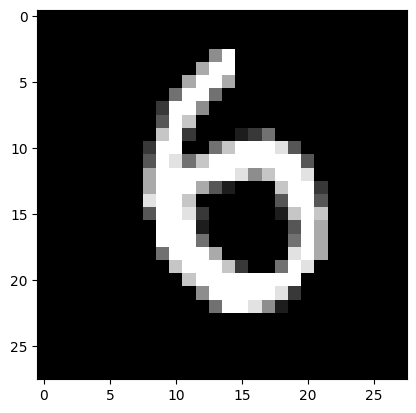

Label: 6


In [ ]:

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[5]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[5]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
print('pixel [0,0]: ',img[0][0])
print('pixel maximo: ', torch.max(img))
print('pixel minimo: ', torch.min(img))

pixel [0,0]:  tensor(-0.4242)
pixel maximo:  tensor(2.8215)
pixel minimo:  tensor(-0.4242)


## 3. Construyo mi CNN

#### Bloque de convolución

defino primero un "bloque" de una capa CNN
construido con los bloques funcionales vistos en clase

argumentos a pasar a la función:

  - `c_in`:   canales (kernels) de entrada
  - `c_out`:  canales (kernels) de salida
  - `k`:      tamaño del kernel kxk
  - `p`:      tamaño del padding de la convolución
  - `s`:      stride de la convolución
  - `pk`:     tamaño del kernel del pooling


la función pooling se elige directamente dentro del bloque!

In [ ]:
# bloque de convolución para emplear en mi red

def conv_block(c_in, c_out, k=3, p='same', s=1, pk=2):
    return torch.nn.Sequential(                               # el módulo Sequential se engarga de hacer el forward de todo lo que tiene dentro.
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk)                                # pooling
    )


### Red convolucional (modelo)


Ahora SI construyo mi red... usando la clase CNN de pytorch
revisar muy bien las dimensiones a emplear en cada capa y
tener presente la reducción de las dimensiones.

En la útlima capa fully conected `fc`, hacer bien el cálculo final del
tamaño del array que se obtiene siguiendo la formula vista en la teoria
tanto para la capa conv como para la capa pooling.

In [ ]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(c_in = n_channels, c_out = 4, k=3, p='same', s=1, pk=2)
    self.conv1_out = None
    self.drop = torch.nn.Dropout2d(p=0.7, inplace=False)
    self.conv2 = conv_block(c_in = 4, c_out = 8, k=3, p='same', s=1, pk=2)
    self.conv2_out = None
    self.fc = torch.nn.Linear(8*7*7, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!


    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)


  def forward(self, x):
    #print('input shape: ', x.shape)
    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    y = self.conv2_out.flatten(start_dim=1)
    #print(y.shape)
    y = self.fc(y)
    return y

In [ ]:
model = CNN()


Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=392, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  4
Número total de parámetros a entrenar:  4266


## 4. Veamos que las dimensiones sean consistentes.

In [ ]:
torchinfo.summary(model, input_size=( 12, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 10]                  --
├─Sequential: 1-1                        [12, 4, 14, 14]           --
│    └─Conv2d: 2-1                       [12, 4, 28, 28]           40
│    └─Tanh: 2-2                         [12, 4, 28, 28]           --
│    └─MaxPool2d: 2-3                    [12, 4, 14, 14]           --
├─Dropout2d: 1-2                         [12, 4, 14, 14]           --
├─Sequential: 1-3                        [12, 8, 7, 7]             --
│    └─Conv2d: 2-4                       [12, 8, 14, 14]           296
│    └─Tanh: 2-5                         [12, 8, 14, 14]           --
│    └─MaxPool2d: 2-6                    [12, 8, 7, 7]             --
├─Dropout2d: 1-4                         [12, 8, 7, 7]             --
├─Linear: 1-5                            [12, 10]                  3,930
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
Total mult-ad

## 5. Armo las funciones necesarias

In [ ]:
# función de entrenamiento
def fit(model, dataloader, epochs=15):
    # enviamos el modelo al device
    model.to(device)
    # definimo optimizer y la función de pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    # preparamos listas para guardar las loss y la acc a lo largo de la epocas
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    # iteramos en las epocas
    for epoch in range(1, epochs+1):
        # ponemos el modelo en train
        model.train()
        # listas de loss y acc de train para esta epoca
        # así despues calculamos la media
        # por que el dataset lo pasamos de a batches
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch  # sacamos X e y del batch
            X, y = X.to(device), y.to(device) # lo enviamos al device
            optimizer.zero_grad() # llevamos optimizer a zero
            y_hat = model(X)  # corremos el modelo y vemos su predicción
            loss = criterion(y_hat, y)  # calculamos la pérdida
            loss.backward() # back-propagations
            optimizer.step()  # step del optimizer
            train_loss.append(loss.item()) # vamos guardando la pérdida de este batch, en la perdida de la epoca
            # calculo de la acc
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc) # vamos guardando la acc de este batch, en la acc de la epoca
            # seteamos descriptores en la barra
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # luego de pasar todo el batch, guardamos la perdida y acc media del train
        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))


        # ahora viene es test
        bar = tqdm(dataloader['test'])
        # listas de loss y acc de test para esta epoca
        # así despues calculamos la media
        # por que el dataset lo pasamos de a batches
        val_loss, val_acc = [], []
        # ponemos en eval el modelo
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

## 6. Entreno la red

In [ ]:
fit(model, dataloader)

val_loss 1.39334 val_acc 0.77617: 100%|██████████| 157/157 [00:02<00:00, 54.24it/s]


Epoch 1/15 loss 2.05428 val_loss 1.39334 acc 0.29339 val_acc 0.77617


val_loss 0.77813 val_acc 0.83788: 100%|██████████| 157/157 [00:02<00:00, 55.40it/s]


Epoch 2/15 loss 1.51278 val_loss 0.77813 acc 0.52572 val_acc 0.83788


val_loss 0.59745 val_acc 0.86654: 100%|██████████| 157/157 [00:02<00:00, 55.36it/s]


Epoch 3/15 loss 1.28463 val_loss 0.59745 acc 0.58452 val_acc 0.86654


val_loss 0.51683 val_acc 0.87550: 100%|██████████| 157/157 [00:02<00:00, 57.14it/s]


Epoch 4/15 loss 1.20716 val_loss 0.51683 acc 0.60379 val_acc 0.87550


val_loss 0.46989 val_acc 0.88097: 100%|██████████| 157/157 [00:03<00:00, 45.16it/s]


Epoch 5/15 loss 1.15474 val_loss 0.46989 acc 0.61794 val_acc 0.88097


val_loss 0.43992 val_acc 0.88515: 100%|██████████| 157/157 [00:03<00:00, 46.69it/s]


Epoch 6/15 loss 1.12811 val_loss 0.43992 acc 0.62382 val_acc 0.88515


val_loss 0.41779 val_acc 0.89112: 100%|██████████| 157/157 [00:02<00:00, 55.98it/s]


Epoch 7/15 loss 1.10360 val_loss 0.41779 acc 0.63151 val_acc 0.89112


val_loss 0.39994 val_acc 0.89291: 100%|██████████| 157/157 [00:02<00:00, 56.15it/s]


Epoch 8/15 loss 1.08452 val_loss 0.39994 acc 0.63293 val_acc 0.89291


val_loss 0.38648 val_acc 0.89480: 100%|██████████| 157/157 [00:02<00:00, 56.62it/s]


Epoch 9/15 loss 1.07585 val_loss 0.38648 acc 0.63556 val_acc 0.89480


val_loss 0.37732 val_acc 0.89729: 100%|██████████| 157/157 [00:03<00:00, 48.35it/s]


Epoch 10/15 loss 1.06010 val_loss 0.37732 acc 0.64131 val_acc 0.89729


val_loss 0.36624 val_acc 0.89918: 100%|██████████| 157/157 [00:03<00:00, 51.43it/s]


Epoch 11/15 loss 1.05064 val_loss 0.36624 acc 0.64292 val_acc 0.89918


val_loss 0.35971 val_acc 0.90078: 100%|██████████| 157/157 [00:02<00:00, 55.49it/s]


Epoch 12/15 loss 1.05127 val_loss 0.35971 acc 0.64214 val_acc 0.90078


loss 1.03857 acc 0.64735:  28%|██▊       | 262/938 [00:05<00:14, 45.15it/s]

## 7. Vemos que funcione.

In [ ]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 2

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))

# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print('Tamaño imagen de entrada a red: ', samp_img.shape)

# la paso al modelo
model.to(device)
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())





# EJERCICIO NRO 1

## Probemos con un número nuestro!
Primero lo dibujamos en el paint con un tamaño próximo a 28x28 pixeles
(el tamaño del papel puede ser aproximado)...
Después haremos un `resize`.
Usar un marcador grueso que pinte varios pixeles!!!!

Cargamos el archivo hecho a mano

In [ ]:
# lo leemos
num_ex = torchvision.io.read_image('cinco.png')
#num_ex= torchvision.io.read_image('/content/drive/My Drive/CIA_marcos/deep_learning/clase_5/tres.png')

Veamos el tamaño, datatype y el valor de 1 pixel.

In [ ]:
print('shape imagen: ', num_ex.shape)
print('data type imagen: ', num_ex.dtype)
# convertimos a float
num_ex = num_ex.float()
print('nuevo data type: ', num_ex.dtype)
print('valor pixel superior izq: ', num_ex[0][0][0])

Realizamos un conjunto de transformaciones para llevar la imagen al valor deseado:
- resize a 28x28
- convertir a escala de grises
- escalar ente 0 y 1 (dividimos por 255)
- normalizar

In [ ]:
adaptacion = torchvision.transforms.Compose([
                                             torchvision.transforms.Resize(size=(28,28)),
                                             torchvision.transforms.Grayscale(num_output_channels=1), #<---------- IMPORTANTE!
                                             torchvision.transforms.Normalize((0,), (255,))#,#<--------- lo escalo entre 0 y 1
                                             #torchvision.transforms.Normalize((0.1307,), (0.3081,)), #<---------- IMPORTANTE!
                                            ])

Una ultima transformación (que no se pudo colocar dentro del compose) es la de invertir los colores, ya que MNIST tiene fondo negro con letra blanca.

In [ ]:
# aplicamos la transformación
num_ex_adap = adaptacion(num_ex)

# para invertir el color (blanco y negro)
num_ex_adap = torchvision.transforms.functional.invert(num_ex_adap)

print('nuevo tamaño de imagen: ', num_ex_adap.shape)
print('pixel [0,0]: ',num_ex_adap[0][0][0])
print('pixel máximo: ', torch.max(num_ex_adap))
print('pixel mínimo: ', torch.min(num_ex_adap))

Veamos como quedó

In [ ]:
# ponemos el squeeze para eliminar el canal (1ra dimension)
plt.imshow(num_ex_adap.squeeze(), cmap='gray')
plt.show()

Lo pasamos por la red...
RECORDAR DE MANEJAR TODO EN EL MISMO `DEVICE`

In [ ]:
# le agregamos el batch y lo mandamos a device
num_ex_adap_batch = num_ex_adap.unsqueeze(0).cpu()
print('Tamaño entrada:   ',num_ex_adap_batch.shape)

# enviamos al modelo al device
model.cpu()
model.eval()
# pasamos la entrada al modelo
y_hat = model(num_ex_adap_batch)
print()
print('Salida red:  ')
print(y_hat.detach())
print()
print('Salida softmax(salida red):')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

El mismo proceso en 1 sola celda.

In [ ]:
# todo junto
num_ex = torchvision.io.read_image('ocho.png').float()
num_ex_adap = adaptacion(num_ex)
num_ex_adap = torchvision.transforms.functional.invert(num_ex_adap)
# le agregamos el batch y lo mandamos a device
num_ex_adap_batch = num_ex_adap.unsqueeze(0).cpu()
model.cpu().eval()

y_hat = model(num_ex_adap_batch)
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())